In [ ]:
# %load_ext pycodestyle_magic
# %flake8_on
# import logging
# logging.getLogger("flake8").setLevel(logging.FATAL)

<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<b>Citzen Science Notebook</b> <br>
Contact author: Sreevani Jarugula <br>
Last verified to run: 2023-04-20 <br>
LSST Science Pipelines version: Weekly 2023_xx <br>
Container size: medium <br>


**Description:**
Query and send variable star images and light curves from RSP to Zooniverse

**Skills:** Use various TAP tables, including joining multiple tables. Get calexp images. Extract time-series photometry.

**LSST Data Products:** TAP tables dp02_dc2_catalogs.MatchesTruth, TruthSummary, ForcedSource, CcdVisit<br>

**Packages:** astropy, lsst.rsp.get_tap_service, lsst.rsp.retrieve_query, lsst.daf.butler, lsst.afw.display, lsst.geom 

**Credit:** Tutorial notebooks 03a, 04a, 04b, 07b, and 08

**Support:** Support is available and questions are welcome - (some email/link etc)

DEBUG VERSION note that this version of the notebook contains additional debugging and the first cell will need to be run once

## 1. Introduction

This notebook is intended to guide a PI through the process of sending variable data from the Rubin Science Platform (RSP) to the Zooniverse. A detailed guide to Citizen Science projects, outlining the process, requirements and support available is here: (link to citscipiguide) The data sent can be currated on the RSP as a necessary and take many forms. Here, we include an example of sending png cutout images of a single variable star over different exposures. We encourage PIs new to the Rubin dataset to explore the tutorial notebooks and documentation.

This notebook will restrict the number of object sent to the Zooniverse to one variable star over five exposures.

### Log in to the Zooniverse Platform & Activate Citizen Science SDK

If you haven't already, create a Zooniverse account here. and create your project. Your project must be set to "public". To set your project to public, select the "Visibility" tab. Note you will need to enter your username, password, and project slug below.

After creating your account and project, return to this notebook.

Supply your email and project slug below.

A "slug" is the string of your Zooniverse username and your project name without the leading forward slash, for instance: "username/project-name".

For more details, see: https://www.zooniverse.org/talk/18/967061?comment=1898157&page=1.

IMPORTANT: Your Zooniverse project must be set to "public", a "private" project will not work. Select this setting under the "Visibility" tab, (it does not need to be set to live). The following code will not work if you have not authenticated in the cell titled "Log in to Zooniverse".

In [1]:
# !pip install --upgrade --force-reinstall --no-deps rubin.citsci --quiet

## 1.1 Package imports

In [1]:
import utils

import matplotlib.pyplot as plt
import gc
import numpy as np
import pandas
import pandas as pd
import time
import os

# Astropy imports
from astropy.wcs import WCS
from astropy.visualization import make_lupton_rgb
from astropy import units as u
from astropy.coordinates import SkyCoord

# Import the Rubin TAP service utilities
from lsst.rsp import get_tap_service, retrieve_query

# Image visualization routines.
import lsst.afw.display as afwDisplay
# The Butler provides programmatic access to LSST data products.
from lsst.daf.butler import Butler
# Geometry package
import lsst.geom as geom
# Object for multi-band exposures
from lsst.afw.image import MultibandExposure

import lsst.daf.butler as dafButler
import lsst.geom
import lsst.afw.display as afwDisplay

# Must explicitly set this to save figures
afwDisplay.setDefaultBackend("matplotlib")


### 1.1.1 Initializing TAP and Butler

In [2]:
config = 'dp02'
collection = '2.2i/runs/DP0.2'
service, butler, skymap = utils.setup_butler(config, collection)

### 1.2 Define Functions and Parameters

### 1.2.1 Variable star related parameters

In [3]:
query_num_stars = 2 # number of variable stars to query 

# Set any RA and DEC in degrees. This is the centre of your search radius
# In this example notebook we are looking at one known RR-Lyrae. 

ra_known_rrl = 62.1479031
dec_known_rrl = -35.799138

search_radius = 0.001 # Search radius in degrees

num_variable_images = 5 # For each variable stars, number of images to query to create flipbook (gif)

image_size = 20 # image size for cutouts

bands = ['g','r','i'] # bands to get flux for to create a lightcurve

### 1.2.4 Create relevant directories

In [4]:
plots = [] # empty list for plots

# main directory
batch_dir = './variable_stars_output/' 

if os.path.isdir(batch_dir) == False:
    os.mkdir(batch_dir)

# cutouts directory
if os.path.isdir(batch_dir+'images') == False:
    os.mkdir(batch_dir+'images')
else:
    os.system('rm -r '+batch_dir+'images/*')

# light curve directory
if os.path.isdir(batch_dir+'lc_plots') == False:
    os.mkdir(batch_dir+'lc_plots')
else:
    os.system('rm -r '+batch_dir+'lc_plots/*')

# light curve text file directory
if os.path.isdir(batch_dir+'text_files') == False:
    os.mkdir(batch_dir+'text_files')
else:
    os.system('rm -r '+batch_dir+'text_files/*')

### 1.2.5 Query and Plotting functions

In [5]:
def query_stars(ra_deg, dec_deg, radius_deg, limit):
    """
    Query variable stars from dp02_dc2_catalogs.MatchesTruth and dc2_catalogs.TruthSummary
    
    To query more than one star within the circle of search, change = 1 to <= 1
    
    Selecting stars (truth_type=2)
    variable (is_variable = 1)
    is_pointsource = 1

    Input Parameters
    ----------
    ra_deg : ra of the centre of search in degrees
    dec_deg : dec of the centre of search in degrees
    radius_deg : radius within which to search for
    limit : number of variable stars to retireve
    
    Returns
    ----------
    Table of variable stars as pandas dataframe
    """
    query = "SELECT mt.id_truth_type, mt.match_objectId, ts.ra, ts.dec "\
            "FROM dp02_dc2_catalogs.MatchesTruth AS mt "\
            "JOIN dp02_dc2_catalogs.TruthSummary AS ts ON mt.id_truth_type = ts.id_truth_type "\
            "WHERE ts.truth_type=2 "\
            "AND ts.is_variable = 1 "\
            "AND ts.is_pointsource = 1 "\
            "AND mt.match_objectId > 1 "\
            "AND CONTAINS(POINT('ICRS', ts.ra, ts.dec), CIRCLE('ICRS', "+ str(ra_deg)+", "+str(dec_deg)+", "+str(radius_deg)+")) <= 1 "\
            "LIMIT "+str(limit)+" "
    results = service.search(query)
    variable_stars = results.to_table().to_pandas()
    return variable_stars

def query_flux(objid):
    """
    Query to get the flux for each variable star at all bands

    Input Parameters
    ----------
    objid : Object ID of the variable star obtained from query_stars
    
    Returns
    ----------
    Table of flux of variable star 
    """
    query = "SELECT src.band, src.ccdVisitId, src.coord_ra, src.coord_dec, "\
            "src.objectId, src.psfFlux, src.psfFluxErr, "\
            "visinfo.detector, visinfo.visitId, "\
            "scisql_nanojanskyToAbMag(psfFlux) as psfMag, "\
            "visinfo.band, "\
            "visinfo.expMidptMJD "\
            "FROM dp02_dc2_catalogs.ForcedSource as src "\
            "JOIN dp02_dc2_catalogs.CcdVisit as visinfo "\
            "ON visinfo.ccdVisitId = src.ccdVisitId "\
            "WHERE src.objectId = "+str(objid)+" "
    table = service.search(query)
    flux_table = table.to_table()
    return flux_table

## testing the deepcoadd imaging

In [12]:
my_star = 1651589610221899038
my_ra_deg = 62.1479018
my_dec_deg = -35.7991382
my_filter = 'i'

In [17]:
my_spherePoint = lsst.geom.SpherePoint(my_ra_deg*lsst.geom.degrees, my_dec_deg*lsst.geom.degrees)

skymap = butler.get('skyMap')
tract = skymap.findTract(my_spherePoint)
my_tract = tract.tract_id
my_patch = tract.findPatch(my_spherePoint).getSequentialIndex()
print('My tract and patch: ', my_tract, my_patch)

my_dataId = {'band': my_filter, 'tract': my_tract, 'patch': my_patch}
my_deepCoadd_wcs = butler.get('deepCoadd.wcs', dataId=my_dataId)

cutoutSize = geom.ExtentI(100, 100)
xy = geom.PointI(my_deepCoadd_wcs.skyToPixel(my_spherePoint))
bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
parameters = {'bbox': bbox}
# print('xy: ',xy)
# print('bbox: ',bbox)

my_deepCoadd = butler.get('deepCoadd', parameters=parameters, dataId=my_dataId)

del my_ra_deg, my_dec_deg, my_filter, my_spherePoint, skymap, tract

My tract and patch:  3831 45


(13716.5, 13816.5, 25597.5, 25697.5)

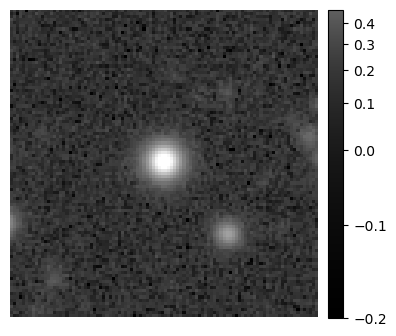

In [18]:
fig = plt.figure(figsize=(6, 4))
afw_display = afwDisplay.Display(1)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(my_deepCoadd.image)
plt.gca().axis('off')

In [19]:
my_coadd_inputs = my_deepCoadd.getInfo().getCoaddInputs()

In [20]:
len(my_coadd_inputs.visits)

136

In [23]:
my_coadd_inputs.visits.asAstropy()

id,bbox_min_x,bbox_min_y,bbox_max_x,bbox_max_y,goodpix,weight,filter
,pix,pix,pix,pix,,,
int64,int32,int32,int32,int32,int32,float64,str32
204710,11900,23900,16099,27999,15503370,4.315546048438744,i_sim_1.4
211199,11900,23900,16099,27999,15575907,1.6160897993241512,i_sim_1.4
211488,11900,23900,16099,27999,15603079,1.831360701618286,i_sim_1.4
211540,11900,23900,16099,27999,15641118,1.799486066487487,i_sim_1.4
211544,11900,23900,16099,27999,15914683,1.8089723915585976,i_sim_1.4
214463,11900,23900,16099,27999,15563302,4.6260464374356784,i_sim_1.4
214517,11900,23900,16099,27999,15604428,4.417556998079759,i_sim_1.4
214520,11900,23900,16099,27999,15651849,4.436038864305851,i_sim_1.4


In [24]:
my_coadd_visits = my_coadd_inputs.visits['id']
my_coadd_visits

array([ 204710,  211199,  211488,  211540,  211544,  214463,  214517,
        214520,  214558,  227882,  228092,  230717,  230776,  244022,
        256381,  262031,  268418,  280218,  280224,  280269,  280270,
        410960,  410985,  410986,  420828,  421642,  421684,  421685,
        433952,  433985,  433986,  433990,  457710,  457711,  458564,
        458603,  471930,  471931,  471957,  472137,  478991,  479542,
        497008,  497043,  518030,  518056,  518092,  641065,  654461,
        654493,  678494,  679387,  679388,  679430,  679432,  679497,
        679529,  682759,  682760,  682761,  686592,  686593,  686629,
        686630,  692695,  692699,  713062,  713095,  713352,  713353,
        713382,  731751,  731781,  731792,  731800,  752164,  766970,
        880167,  880204,  917382,  924093,  924164,  924173,  924174,
        929449,  930376,  930406,  930407,  930426,  932374,  932414,
        934147,  941057,  945589,  945590,  945618,  945638,  951330,
        951390,  966

In [27]:
np.sort(np.array(test_df["visitId"]))

array([ 204710,  211199,  211488,  211540,  211544,  214463,  214517,
        214520,  214558,  230717,  230776,  244022,  256381,  262031,
        280218,  280224,  280269,  410960,  420828,  421642,  421685,
        433952,  433985,  433986,  433990,  457710,  457711,  471931,
        471957,  479542,  497008,  497043,  518030,  518056,  654461,
        654493,  679387,  679430,  679432,  679497,  679529,  682759,
        682760,  682761,  686592,  686593,  686629,  686630,  713062,
        713095,  713353,  713382,  731781,  731792,  731800,  752164,
        766970,  880167,  917382,  924164,  924173,  924174,  930376,
        930407,  930426,  932374,  932414,  934147,  941057,  945590,
        945638,  951390,  966810,  966878,  976122,  976145,  976280,
        976353,  976410,  994946, 1013680, 1013703, 1013742, 1030667,
       1165691, 1165692, 1165731, 1165836, 1165869, 1196500, 1197823,
       1197824, 1197851, 1197857, 1209140, 1211957, 1211958, 1212006,
       1212007, 1217

In [21]:
test_variable_star = 1651589610221899038
test_df = query_flux(test_variable_star)
test_df = test_df[test_df["band"] == 'i']

In [22]:
print((len(test_df)))
test_df

101


band,ccdVisitId,coord_ra,coord_dec,objectId,psfFlux,psfFluxErr,detector,visitId,psfMag,band2,expMidptMJD
,,deg,deg,,nJy,nJy,,,,,d
object,int64,float64,float64,int64,float64,float64,int64,int64,float64,object,float64
i,1217196168,62.1479018,-35.7991382,1651589610221899038,159190.8745744,555.2260499,168,1217196,18.395204578235376,i,61371.2830422
i,654461035,62.1479018,-35.7991382,1651589610221899038,196662.5053813,589.7649597,35,654461,18.165696081114035,i,60549.2712432
i,211544139,62.1479018,-35.7991382,1651589610221899038,235804.8056071,660.9748068,139,211544,17.96861837100967,i,59866.3557842
i,1030667047,62.1479018,-35.7991382,1651589610221899038,178396.4907086,670.5837285,47,1030667,18.271534232535394,i,61098.0866502
i,1211958011,62.1479018,-35.7991382,1651589610221899038,150720.1844131,529.7832338,11,1211958,18.454571457928836,i,61364.1963772
i,1211957180,62.1479018,-35.7991382,1651589610221899038,151386.2874726,532.118379,180,1211957,18.44978365331655,i,61364.1959242
i,1212006157,62.1479018,-35.7991382,1651589610221899038,150347.3364862,539.7693704,157,1212006,18.45726065335482,i,61364.2191292
i,214517059,62.1479018,-35.7991382,1651589610221899038,152990.8902348,503.1066354,59,214517,18.43833607064463,i,59870.2435682


In [29]:
test_df.sort(['expMidptMJD'])
test_df

band,ccdVisitId,coord_ra,coord_dec,objectId,psfFlux,psfFluxErr,detector,visitId,psfMag,band2,expMidptMJD
,,deg,deg,,nJy,nJy,,,,,d
object,int64,float64,float64,int64,float64,float64,int64,int64,float64,object,float64
i,204710038,62.1479018,-35.7991382,1651589610221899038,189598.4066266,546.6713629,38,204710,18.205413291917125,i,59857.3493782
i,211199139,62.1479018,-35.7991382,1651589610221899038,150736.6415147,582.5420544,139,211199,18.45445291311901,i,59866.1896572
i,211488103,62.1479018,-35.7991382,1651589610221899038,214048.5024568,636.7216758,103,211488,18.073719515661814,i,59866.3260852
i,211540121,62.1479018,-35.7991382,1651589610221899038,236087.2254468,660.9506534,121,211540,17.967318779317775,i,59866.3539772
i,211544139,62.1479018,-35.7991382,1651589610221899038,235804.8056071,660.9748068,139,211544,17.96861837100967,i,59866.3557842
i,214463171,62.1479018,-35.7991382,1651589610221899038,156452.9933943,491.6224328,171,214463,18.414040307849437,i,59870.2187202
i,214517059,62.1479018,-35.7991382,1651589610221899038,152990.8902348,503.1066354,59,214517,18.43833607064463,i,59870.2435682
i,214520098,62.1479018,-35.7991382,1651589610221899038,152850.3348285,497.9342811,98,214520,18.439334013967063,i,59870.2449302


In [16]:
print(len(np.unique(test_df["detector"])))
print(np.max(test_df["detector"]))

90
188


In [17]:
print(len(np.unique(test_df["visitId"])))

115


## Getting custom deepcoadds using tutorial_notebook 09a

## 2. Query and plot the variable stars

In [8]:
%%time
variable_stars = query_stars(ra_known_rrl, dec_known_rrl, search_radius, query_num_stars)

CPU times: user 16.4 ms, sys: 6.75 ms, total: 23.2 ms
Wall time: 1.43 s


In [9]:
variable_stars

,id_truth_type,match_objectId,ra,dec
0,40745496103_2,1251666444874161581,65.542978,-44.480496
1,40897600536_2,1251666444874186330,65.552173,-44.549350


### 2.1 Get Calexp images and Lightcurves

How to create csv for Zooniverse flipbook

https://help.zooniverse.org/getting-started/example/#details-subject-sets-and-manifest-details-aka-what-is-a-manifesthttps://help.zooniverse.org/getting-started/example/#details-subject-sets-and-manifest-details-aka-what-is-a-manifestCreate 


In [10]:
def get_cutout_image(butler, ra_deg, dec_deg, visit, detector, band, cutoutSideLength, datasetType='calexp'):
    """
    Get the cutout image information from butler. 
    This shoudl be followed by make_fig

    Input Parameters
    ----------
    ra : ra of source in degrees
    dec : dec of source in degrees
    visit : visit id
    detector : detector number
    band : band to get cutput for
    cutoutSideLength : size of the cutout
    
    Returns
    ----------
    Cutout image information
    """
    cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)
    
    radec = geom.SpherePoint(ra_deg,dec_deg, geom.degrees)
    
    dataId = {'visit': visit, 'detector': detector}  
    calexp_wcs = butler.get('calexp.wcs', **dataId)
    
    print('calexp wcs: ', calexp_wcs)
    
    xy = geom.PointI(calexp_wcs.skyToPixel(radec))
    bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
    parameters = {'bbox': bbox}
    print('xy: ',xy)
    print('bbox: ',bbox)
    
    cutout_image = butler.get('calexp', parameters=parameters, **dataId)
    
    return cutout_image
    
    
def make_calexp_fig(cutout_image, ra, dec, out_name):
    """
    Create an image.
    should be followed with remove_figure
    
    Parameters
    ----------
    cutout_image : cutout_image from butler.get
    ra : ra of source in degrees
    dec : dec of source in degrees
    out_name : file name where you'd like to save it
    
    Returns
    ----------
    cutout image
    """
    # fig = plt.figure(figsize=(4, 4))
    # afw_display = afwDisplay.Display(frame=fig)
    # afw_display.scale('asinh', 'zscale')
    # afw_display.mtv(cutout_image.image)
    
#     cutout_wcs = cutout_image.getWcs()
#     radec = geom.SpherePoint(ra, dec, geom.degrees)
#     xy = geom.PointI(cutout_wcs.skyToPixel(radec))
    
#     afw_display.dot('x', xy.getX(), xy.getY(), size=1, ctype='orange')
#     plt.gca().axis('off')
#     plt.savefig(out_name)
    
    fig = plt.figure()
    plt.subplot(projection=WCS(cutout_image.getWcs().getFitsMetadata()))
    
    #print('wcs ra: ', cutout_image.getWcs().getFitsMetadata()['CRVAL1'])
    #print('wcs dec: ', cutout_image.getWcs().getFitsMetadata()['CRVAL2'])
    
    calexp_extent = (cutout_image.getBBox().beginX, cutout_image.getBBox().endX,
                 cutout_image.getBBox().beginY, cutout_image.getBBox().endY)
    im = plt.imshow(cutout_image.image.array, cmap='gray', vmin=-200.0, vmax=1000,
                extent=calexp_extent, origin='lower')
    plt.colorbar(location='right', anchor=(0, 0.1))
    # plt.gca().axis('off')
    plt.xlabel('Right Ascension')
    plt.ylabel('Declination')
    plt.savefig(out_name)
    
    return fig


In [11]:
plot_filter_symbols = {'u': 'o', 'g': '^', 'r': 'v', 'i': 's', 'z': '*', 'y': 'p'}
plot_filter_labels = {'u':'u', 'g':'g', 'r':'r', 'i':'i', 'z':'z', 'y':'y'}
plot_filter_colors = {'u': '#56b4e9', 'g': '#008060', 'r': '#ff4000',
                      'i': '#850000', 'z': '#6600cc', 'y': '#000000'}
def plotlc(bands, days, magnitudes, out_name):
    """
    Create a light curve.

    Input Parameters
    ----------
    days : dictionary for MJD in each band 
    magnitudes : dictionary for flux in each band
    out_name : file name where you'd like to save it
    
    Returns
    ----------
    light curve image
    """

    fig = plt.figure(figsize=(10,4))
    for band in bands:
        plt.plot(days[band], magnitudes[band] - np.mean(magnitudes[band]),\
                 plot_filter_symbols[band], ms=4, label=plot_filter_labels[band])
    plt.minorticks_on()
    plt.xlabel('MJD (days)')
    plt.ylabel('magnitude')
    plt.legend('upper right')
    plt.legend()
    plt.savefig(out_name)
    return fig

def remove_figure(fig):
    """
    Remove a figure to reduce memory footprint.
    Parameters
    ----------
    fig: matplotlib.figure.Figure
        Figure to be removed.
    Returns
    -------
    None
    """
    # get the axes and clear their images
    for ax in fig.get_axes():
        for im in ax.get_images():
            im.remove()
    fig.clf()       # clear the figure
    plt.close(fig)  # close the figure

    gc.collect()    # call th

In [15]:
stars_matchid

array([1251666444874161581, 1251666444874186330])

In [12]:
stars_matchid = variable_stars['match_objectId'].to_numpy()
stars_ra = variable_stars['ra'].to_numpy()
stars_dec = variable_stars['dec'].to_numpy()
df_row = []
df_final = []

fields_to_add = ["sourceId", "coord_ra", "coord_dec"] # fields to add to the maifest file

for j, objid in enumerate(stars_matchid):
# for j, objid in enumerate(["1251270620688185329"]):
    cutouts = []
    
    figout_data = {"sourceId": stars_matchid[j]}
    if "coord_ra" in fields_to_add:
        figout_data["coord_ra"] = stars_ra[j]
    if "coord_dec" in fields_to_add:
        figout_data["coord_dec"] = stars_dec[j]
    
    # Query the variable star flux, detector and visit information
    ccd_flux_table = query_flux(objid)
    
    # Get calexp images from Butler and plot them
    idx_images = np.round(np.linspace(0, len(ccd_flux_table) - 1, num_variable_images)).astype(int)  #randomly select 5 images for each variable star
    image_dict = {} 
    
    for i,idx in enumerate(idx_images):
        star_ra = ccd_flux_table['coord_ra'][idx]
        star_dec = ccd_flux_table['coord_dec'][idx]
        star_detector = ccd_flux_table['detector'][idx]
        star_visitid = ccd_flux_table['visitId'][idx]
        star_id = ccd_flux_table['objectId'][idx]
        star_ccdid = ccd_flux_table['ccdVisitId'][idx]
        
        calexp_image = get_cutout_image(butler, star_ra, star_dec, star_visitid, star_detector, 'r', image_size, datasetType='calexp') # only r-band images 
        figout = make_calexp_fig(calexp_image, star_ra,star_dec,batch_dir+"/images/"+str(star_id)+"_"+str(star_ccdid)+".png")
        remove_figure(figout)
        
        figout_data['location:image_'+str(i)] = str(star_id)+"_"+str(star_ccdid)+".png"
        figout_data['filename'] = str(star_id)+"_"+str(star_ccdid)+".png"
        
    cutouts.append(figout_data)
    
    # manifest file
    df_star = pd.DataFrame(data = cutouts, index=[0])
    df_final.append(df_star)
    
    # flipbook data for each variable star
    df = pd.DataFrame(data = image_dict, index=[0])
    df_row.append(df)
        
    # Light curve for each variable star    
    mjd_days, mags = utils.get_flux(ccd_flux_table)
    figout = utils.plotlc(bands, mjd_days, mags, batch_dir+"/lc_plots/"+"lc_"+str(objid)+".png")
    remove_figure(figout) 
    df_all_bands = []
    for band in bands:
        df = pd.DataFrame(data = {'band': [band]*len(mjd_days[band]), 'mjd_days': mjd_days[band], \
                          'mags': mags[band]}, index=None)
        df_all_bands.append(df)
    
    df_final_lc = pd.concat(df_all_bands)
    outfile = batch_dir+"/text_files/"+"lc_"+str(objid)+".csv"
    df_final_lc.to_csv(outfile, index=False, sep=',')
    
df_manifest = pd.concat(df_final) # final manifest file with all variable stars
outfile = batch_dir+"images/manifest.csv"
df_manifest.to_csv(outfile, index=False, sep=',')


calexp wcs:  FITS standard SkyWcs:
Sky Origin: (65.5143744305, -44.3843994081)
Pixel Origin: (2111.39, 1895)
Pixel Scale: 0.20025 arcsec/pixel
xy:  (553, 1063)
bbox:  (minimum=(543, 1053), maximum=(562, 1072))
calexp wcs:  FITS standard SkyWcs:
Sky Origin: (65.5493791587, -44.4440750130)
Pixel Origin: (1990.27, 1984.82)
Pixel Scale: 0.199799 arcsec/pixel
xy:  (2558, 1646)
bbox:  (minimum=(2548, 1636), maximum=(2567, 1655))
calexp wcs:  FITS standard SkyWcs:
Sky Origin: (65.3671837245, -44.4031638030)
Pixel Origin: (1907.07, 1933.07)
Pixel Scale: 0.199708 arcsec/pixel
xy:  (3888, 160)
bbox:  (minimum=(3878, 150), maximum=(3897, 169))
calexp wcs:  FITS standard SkyWcs:
Sky Origin: (65.4458206288, -44.5752381419)
Pixel Origin: (1886.48, 1899.73)
Pixel Scale: 0.199753 arcsec/pixel
xy:  (2695, 3856)
bbox:  (minimum=(2685, 3846), maximum=(2704, 3865))
calexp wcs:  FITS standard SkyWcs:
Sky Origin: (65.4253084290, -44.5376156985)
Pixel Origin: (2350.55, 2092.55)
Pixel Scale: 0.200033 arcsec/p

In [13]:
# cutout_dir = batch_dir+"images/"

In [14]:
# manifest_path = write_metadata_file(cutouts, cutout_dir)

# print("The manifest CSV file can be found at the following relative path:")
# print(manifest_path)

## 3. Send data to Zooniverse

In [18]:
cutout_dir = batch_dir+"images/"

In [19]:
subject_set_name = "test_flipbook" 

In [20]:
cit_sci_pipeline.send_image_data(subject_set_name, cutout_dir)

'1. Checking batch status'

'2. Zipping up all the astro cutouts - this can take a few minutes with large data sets, but unlikely more than 10 minutes.'

'3. Uploading the citizen science data'

'4. Creating a new Zooniverse subject set'

'5. Notifying the Rubin EPO Data Center of the new data, which will finish processing of the data and notify Zooniverse'

'** Additional information:'

'6. Sending the manifest URL to Zooniverse'

'** Information: subject_set.id: 115702; manifest: https://storage.googleapis.com/citizen-science-data-public/110bbbc3-7d41-4086-9461-a95ab7d4e68f/manifest.csv'

'7. Transfer process complete, but further processing is required on the Zooniverse platform and you will receive an email at jsv1206@gmail.com'